In [1]:

# Set up notebook
%pprint
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import (fu, nu, DataFrame, to_datetime, Series, np, osp, display)
from datetime import date, timedelta
import os
from IPython.display import HTML
import pandas as pd

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 401177 332 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 332 332 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 486 332 48

triage_paper_df 401177 332 111
file_stats_df 332 332 19
scene_stats_df 486 332 48


In [4]:

# Merge all scenes
filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_dataframe(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=[
        'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category', 'file_name', 'session_file_name',
        'encounter_layout'
    ],
    patient_count_filter_fn=filter_fn
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 121

elevens_df 399048 331 120



# Time To Hemorrhage Control

We have struggled with how to "score" performance on the dead and expectant patients since the inception of this system. The correct answer for these is: SHOULD TAKE PULSE AND PERFORM OTHER PATIENT ASSESSMENTS (Check for breathing, movement, etc) provide NO TREATMENTS, and apply tag. With the dead patient in the first 11...there are six injuries that should NOT be treated. So the challenge is how to score the action of NOT treating them as a correct response. 

Ideally, applying hemorrhage control treatment to either a dead or expectant patient should not be counted...unless it is to give credit for the correct response of not treating them (This has been difficult to program). If calculating the time to hemorrhage control per patient, you could do one of two things with dead and expectant patients: 1) Use an alternative measure as an indicator of proper treatment...for example, perhaps time to correct triage tag (black of gray) could be used as a measure of time to hemorrhage control because it is an indicator that the first responder correctly interpreted the patient condition and chose not to treat bleeding wounds. OR 2) Remove dead or expectant patients from the computation of time to hemorrhage control and reduce the denominator for calculating total time to hemorrhage control by excluding the number of dead and expectant patients.  

## 1) Use an alternative measure as an indicator of proper treatment

In [5]:

# Populate a dataset with the columns needed to compute time to hemorrhage control
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in elevens_df.groupby(fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
    row_dict['scene_start'] = fu.get_scene_start(patient_df)
    row_dict['patient_dead'] = fu.get_is_patient_dead(patient_df)
    try:
        mask_series = ~patient_df.patient_record_salt.isnull()
        salt_srs = patient_df[mask_series].sort_values('action_tick').iloc[-1]
        row_dict['patient_record_salt'] = salt_srs.patient_record_salt
        row_dict['action_tick'] = salt_srs.action_tick
    except Exception:
        row_dict['patient_record_salt'] = fu.get_max_salt(patient_df)
        row_dict['action_tick'] = patient_df.action_tick.max()
    try:
        mask_series = ~patient_df.tool_applied_type.isnull()
        srs = patient_df[mask_series].sort_values('action_tick').iloc[-1]
        row_dict['tool_applied_type'] = srs.tool_applied_type
    except Exception: row_dict['tool_applied_type'] = 'Naso'
    for injury_id, injury_df in patient_df.groupby('injury_id'):
        row_dict['injury_id'] = injury_id
        try:
            mask_series = ~injury_df.injury_record_required_procedure.isnull()
            srs = injury_df[mask_series].sort_values('action_tick').iloc[-1]
            row_dict['injury_record_required_procedure'] = srs.injury_record_required_procedure
        except Exception: row_dict['injury_record_required_procedure'] = 'none'
        try:
            mask_series = ~injury_df.injury_treated_required_procedure.isnull()
            srs = injury_df[mask_series].sort_values('action_tick').iloc[-1]
            row_dict['injury_treated_required_procedure'] = srs.injury_treated_required_procedure
        except Exception: row_dict['injury_treated_required_procedure'] = 'none'
        row_dict['injury_hemorrhage'] = fu.get_is_injury_hemorrhage(injury_df)
        row_dict['hemorrhage_tool_applied'] = fu.get_is_hemorrhage_tool_applied(injury_df, logs_df=patient_df)
        rows_list.append(row_dict)
hemorrhages_df = DataFrame(rows_list)
mask_series = hemorrhages_df.patient_dead & hemorrhages_df.injury_hemorrhage
df = hemorrhages_df[mask_series].groupby(['hemorrhage_tool_applied']).size()
df.loc[True]

21

In [6]:

# Add the time to hemorrhage control column
base_mask_series = hemorrhages_df.patient_dead & hemorrhages_df.injury_hemorrhage & hemorrhages_df.hemorrhage_tool_applied
for (session_uuid, scene_id), scene_df in hemorrhages_df.groupby(fu.scene_groupby_columns):
    scene_start = scene_df.scene_start.min()
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        mask_series = True
        for cn in fu.patient_groupby_columns: mask_series &= (hemorrhages_df[cn] == eval(cn))
        time_to_hemorrhage_control = fu.get_time_to_hemorrhage_control(patient_df, scene_start, use_dead_alternative=False, verbose=False)
        hemorrhages_df.loc[mask_series, 'time_to_hemorrhage_control_undead'] = time_to_hemorrhage_control
        time_to_hemorrhage_control = fu.get_time_to_hemorrhage_control(patient_df, scene_start, use_dead_alternative=True, verbose=False)
        hemorrhages_df.loc[mask_series, 'time_to_hemorrhage_control_dead'] = time_to_hemorrhage_control

In [7]:

# Get the hemorrhage-tool-applied-to-the-dead series and its counterpart
srs1 = hemorrhages_df[base_mask_series].time_to_hemorrhage_control_undead.dropna()
print(srs1.shape)
srs2 = hemorrhages_df[~base_mask_series].time_to_hemorrhage_control_undead.dropna()
print(srs2.shape)
srs3 = hemorrhages_df[base_mask_series].time_to_hemorrhage_control_dead.dropna()
print(srs3.shape)
srs4 = hemorrhages_df[~base_mask_series].time_to_hemorrhage_control_dead.dropna()
print(srs4.shape)

(21,)
(5911,)
(21,)
(5911,)


In [8]:

# Summarize the size of the groups in a sentence
mask_series = hemorrhages_df.patient_dead & hemorrhages_df.injury_hemorrhage
df = hemorrhages_df[mask_series].groupby(['hemorrhage_tool_applied']).size()
print(
    f'In the registry, there are {df.loc[True]} cases where a hemorrhage tool was applied to a hemorrhage injury on a dead patient, but {df.loc[False]:,}'
    ' cases where the injury was ignored.'
)

In the registry, there are 21 cases where a hemorrhage tool was applied to a hemorrhage injury on a dead patient, but 1,863 cases where the injury was ignored.


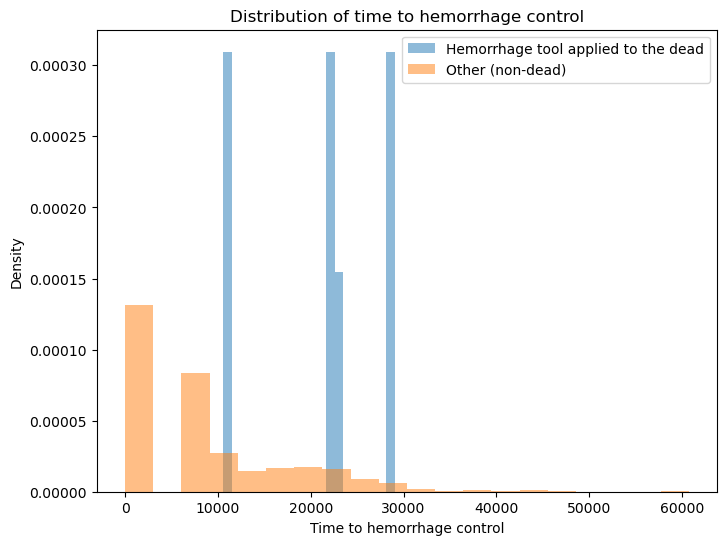

In [15]:

# Normalize the groups such that the area under each histogram sums to 1
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histograms with adjusted bins and density
# ax.hist(srs1, bins=20, label='Hemorrhage tool applied to the undead', alpha=0.5, density=False)
# ax.hist(srs2, bins=20, label='Other (non-undead)', alpha=0.5, density=False)
ax.hist(srs3, bins=20, label='Hemorrhage tool applied to the dead', alpha=0.5, density=True)
ax.hist(srs4, bins=20, label='Other (non-dead)', alpha=0.5, density=True)

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Time to hemorrhage control')
plt.ylabel('Density')
plt.title('Distribution of time to hemorrhage control')

# Show plot
plt.show()


## Reduce the denominator for calculating total time to hemorrhage control

Remove dead or expectant patients from the computation of time to hemorrhage control and reduce the denominator for calculating total time to hemorrhage control by excluding the number of dead and expectant patients.

In [17]:

hemorrhages_df[base_mask_series].sample(10).T.sort_index()

4421  \
action_tick                                                       35967   
hemorrhage_tool_applied                                            True   
injury_hemorrhage                                                  True   
injury_id                                             R Shin Amputation   
injury_record_required_procedure                             tourniquet   
injury_treated_required_procedure                                  none   
patient_dead                                                       True   
patient_id                                                   Bob_0 Root   
patient_record_salt                                                DEAD   
scene_id                                                              0   
scene_start                                                        6910   
session_uuid                       c7587083-faff-4bca-b678-ae156bd4a3f0   
time_to_hemorrhage_control_dead                                 29057.0   
time_to_hemorrhage_control_undead                                   0.0   
tool_applied_type                                            Tourniquet   

                                                                   3820  \
action_tick                                                       14460   
hemorrhage_tool_applied                                            True   
injury_hemorrhage                                                  True   
injury_id                                             R Shin Amputation   
injury_record_required_procedure                             tourniquet   
injury_treated_required_procedure                                  none   
patient_dead                                                       True   
patient_id                                                   Bob_0 Root   
patient_record_salt                                                DEAD   
scene_id                                                              0   
scene_start                                                        3862   
session_uuid                       a437d61b-adad-424f-9714-83382548fda2   
time_to_hemorrhage_control_dead                                 10598.0   
time_to_hemorrhage_control_undead                                   0.0   
tool_applied_type                                            Tourniquet   

                                                                   251   \
action_tick                                                       25628   
hemorrhage_tool_applied                                            True   
injury_hemorrhage                                                  True   
injury_id                                             R Shin Amputation   
injury_record_required_procedure                             tourniquet   
injury_treated_required_procedure                                  none   
patient_dead                                                       True   
patient_id                                                   Bob_0 Root   
patient_record_salt                                                DEAD   
scene_id                                                              0   
scene_start                                                        3808   
session_uuid                       0b01cf49-87cc-4647-9f29-b8dff39dcd6c   
time_to_hemorrhage_control_dead                                 21820.0   
time_to_hemorrhage_control_undead                                   0.0   
tool_applied_type                                            Tourniquet   

                                                                   3822  \
action_tick                                                       14460   
hemorrhage_tool_applied                                            True   
injury_hemorrhage                                                  True   
injury_id                                             R Shin Amputation   
injury_record_required_procedure                             tourniquet   
injury_treated

In [9]:

mask_series = ~elevens_df.injury_treated_required_procedure.isnull()
df = elevens_df[mask_series].dropna(axis='columns', how='all')
# mask_series = df.tool_applied_patient_id.isnull()
df.T#[mask_series]

50      \
action_type                                                                          INJURY_TREATED   
action_tick                                                                                 127628   
event_time                                                                      2023-03-10 07:55:43   
session_uuid                                                   cf714cd2-2824-4ad2-8d98-3199b1df0bdb   
file_name                                           All CSV files renamed by date/03.10.23.0753.csv   
logger_version                                                                                  1.0   
injury_treated_id                                                                  R Chest Collapse   
injury_treated_patient_id                                                               Mike_3 Root   
injury_treated_required_procedure                                                        decompress   
injury_treated_severity                                                                        high   
injury_treated_body_region                                                                    chest   
injury_treated_injury_treated                                                                  True   
injury_treated_injury_treated_with_wrong_treatment                                            False   
injury_treated_injury_injury_locator                                                (0.0, 0.0, 0.0)   
scene_id                                                                                       0   
patient_id                                                                              Mike_3 Root   
location_id                                                                         (0.0, 0.0, 0.0)   
injury_id                                                                          R Chest Collapse   
is_scene_aborted                                                                              False   
scene_type                                                                              Orientation   
is_a_one_triage_file                                                                           True   

                                                                                             128     \
action_type                                                                          INJURY_TREATED   
action_tick                                                                                 182895   
event_time                                                                      2023-03-10 07:56:38   
session_uuid                                                   cf714cd2-2824-4ad2-8d98-3199b1df0bdb   
file_name                                           All CSV files renamed by date/03.10.23.0753.csv   
logger_version                                                                                  1.0   
injury_treated_id                                                                L Thigh Laceration   
injury_treated_patient_id                                                               Mike_1 Root   
injury_treated_required_procedure                                                        tourniquet   
injury_treated_severity                                                                      medium   
injury_treated_body_region                                                                  leftLeg   
injury_treated_injury_treated                                                                  True   
injury_treated_injury_treated_with_wrong_treatment                                            False   
injury_treated_injury_injury_locator                                                (2.9, 0.3, 0.4)   
scene_id                                                                                       0   
patient_id                                                                              Mike_1 Root   
location_id                                                                        


Is hemorrhage control merely applying a tourniquet? Is it also applying a packing gauze (but not applying a dressing gauze)? Does a gaze count as engagement with the patient? Does hemorrhage control count on a dead patient?

In [4]:

# Estimating the time to hemorrhage control
if nu.pickle_exists('notice_to_control_time_df'):
    notice_to_control_time_df = nu.load_object('notice_to_control_time_df')
else:
    
    # Create a mask to filter rows where 'injury_treated_required_procedure' is 'tourniquet' or 'woundpack'
    mask_series = elevens_df.injury_treated_required_procedure.isin(['tourniquet', 'woundpack'])
    
    # Define columns for grouping
    
    
    # Group the Data Frame based on the defined columns and filter by the mask
    gb = elevens_df[mask_series].sort_values(['action_tick']).groupby(fu.patient_groupby_columns)
    
    # Create an empty list to store the row dictionaries
    rows_list = []
    
    # Iterate over the groupby object
    for (session_uuid, scene_id, patient_id), controlled_bleeder_df in gb:
    
        # Create a dictionary to store the row data
        row_dict = {}
        
        # Add the groupby columns, logger version and scene categories
        for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
        logger_version = fu.get_logger_version(controlled_bleeder_df)
        row_dict['logger_version'] = logger_version
        is_scene_aborted = fu.get_is_scene_aborted(controlled_bleeder_df)
        row_dict['is_scene_aborted'] = is_scene_aborted
        scene_type = fu.get_scene_type(controlled_bleeder_df)
        row_dict['scene_type'] = scene_type
        
        # Get the first time to hemorrhage control
        first_control = controlled_bleeder_df.action_tick.min()
        row_dict['first_control'] = first_control
    
        # Get the patient's entire history and first notice
        mask_series = True
        for cn in fu.patient_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
        patient_df = elevens_df[mask_series]
        first_notice = fu.get_first_patient_interaction(patient_df)
        row_dict['first_notice'] = first_notice
        
        # Get the body region info
        mask_series = ~patient_df.injury_treated_body_region.isnull()
        if mask_series.any():
            injury_treated_body_region = patient_df[mask_series].injury_treated_body_region.squeeze()
            row_dict['injury_treated_body_region'] = injury_treated_body_region
    
        # Calculate the time from notice to control
        row_dict['notice_to_control_time'] = first_control - first_notice
    
        # Get the first action with the patient
        first_action = fu.get_first_patient_interaction(patient_df)
        row_dict['first_action'] = first_action
    
        # Calculate the time from action to control
        row_dict['action_to_control_time'] = first_control - first_action
    
        # Add the row dictionary to the list
        rows_list.append(row_dict)
    
    # Create a data frame from the list of row dictionaries
    notice_to_control_time_df = DataFrame(rows_list)
    nu.store_objects(notice_to_control_time_df=notice_to_control_time_df)

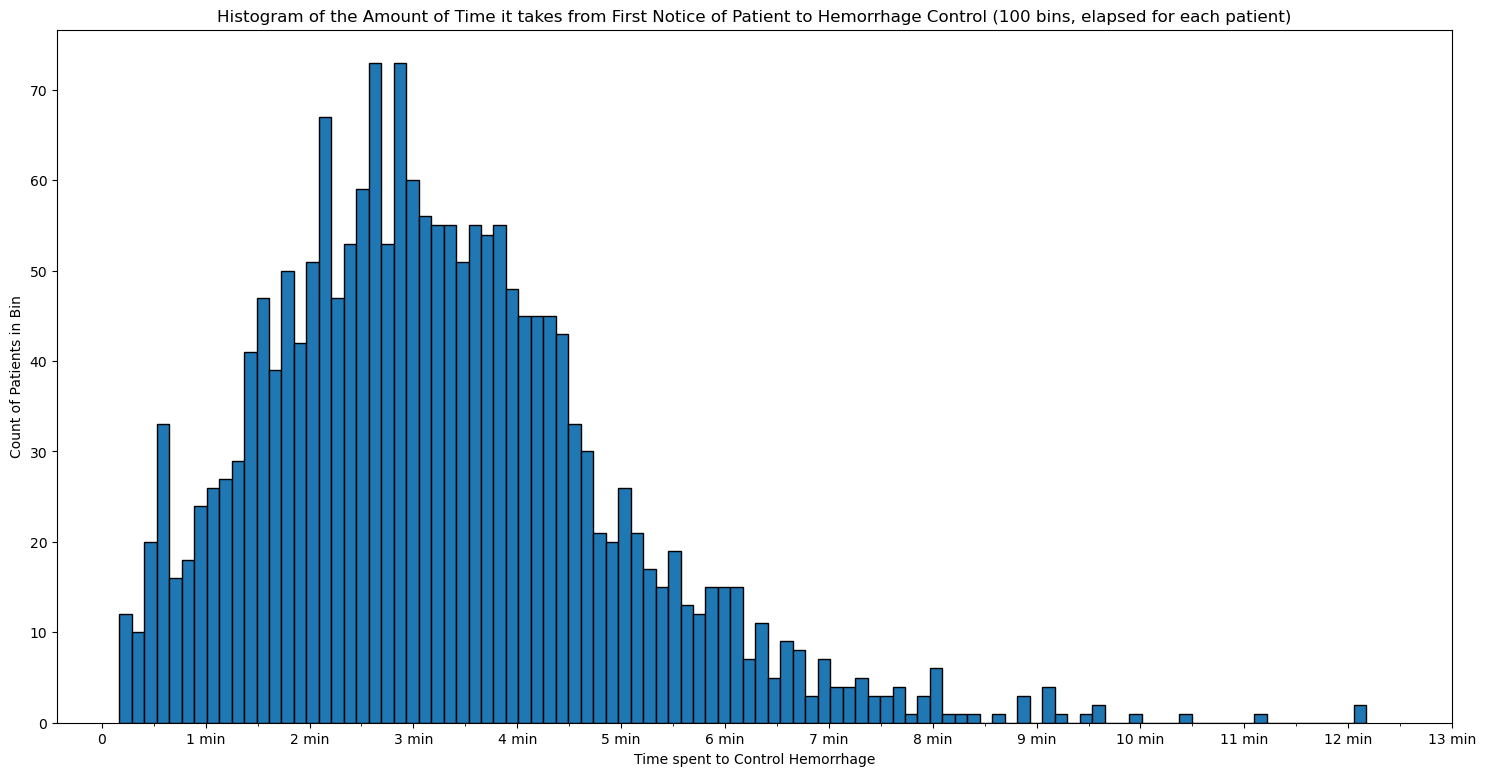

In [5]:

# Histogram of the time it takes from first notice to hemorrhage control for each patient
xlabel = 'Time spent to Control Hemorrhage'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta_lambda(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the Amount of Time it takes from First Notice of Patient to Hemorrhage Control (100 bins, elapsed for each patient)'
ylabel = 'Count of Patients in Bin'
mask_series = (notice_to_control_time_df.scene_type == 'Triage') & (notice_to_control_time_df.is_scene_aborted == False)
ax = nu.plot_histogram(
    notice_to_control_time_df[mask_series], 'notice_to_control_time', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True
)

In [6]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (notice_to_control_time_df.scene_type == 'Triage') & (notice_to_control_time_df.is_scene_aborted == False)
columns_list = [
    'notice_to_control_time'
]
df = notice_to_control_time_df[mask_series][columns_list]
fu.show_time_statistics(df, columns_list)

mean  mode median     SD min   25%   50%   75%    max
notice_to_control_time  3:15  1:55   3:04  ±1:40  10  2:05  3:04  4:11  12:10

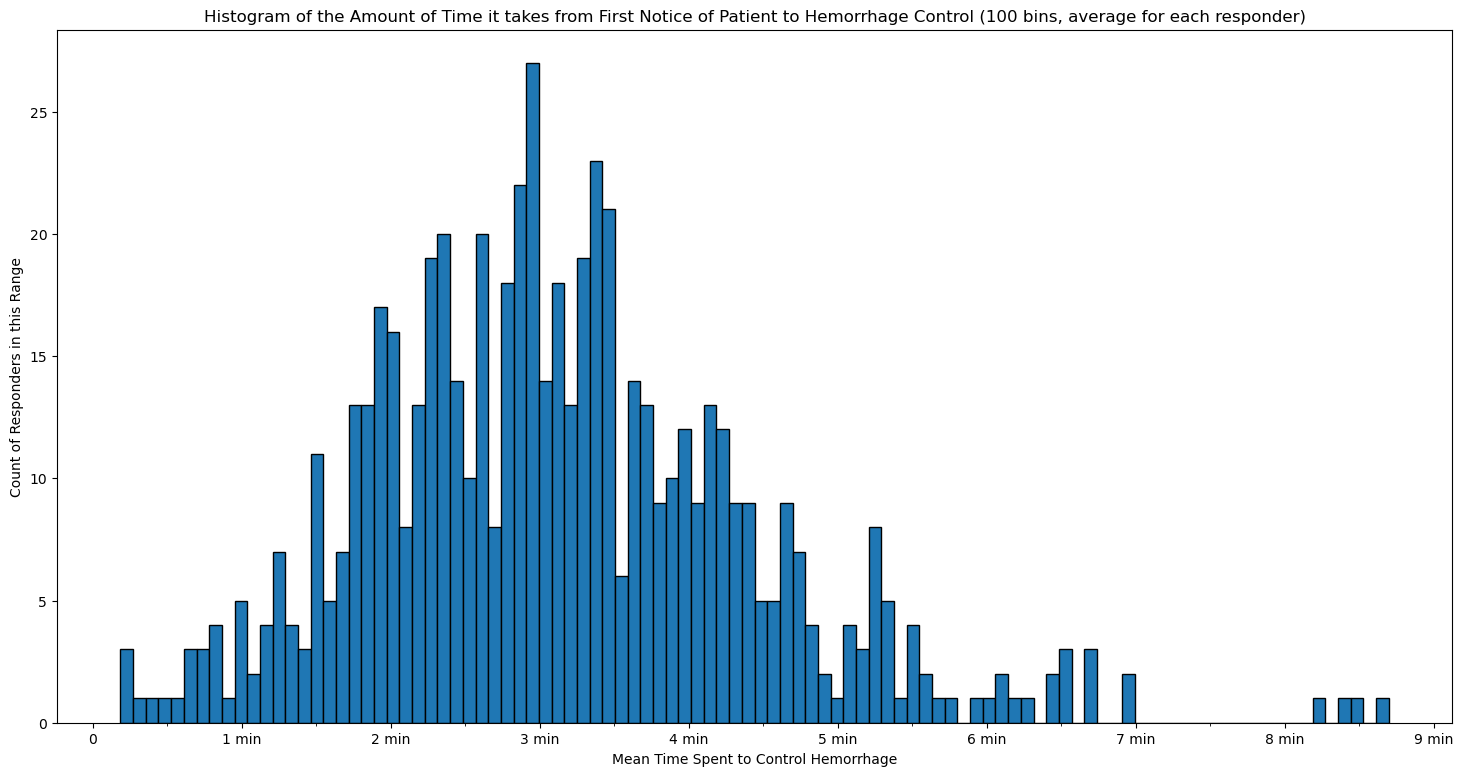

In [7]:

# Histogram of the average amount of time it takes from first notice to hemorrhage control for each responder
mask_series = (notice_to_control_time_df.scene_type == 'Triage') & (notice_to_control_time_df.is_scene_aborted == False)
df = notice_to_control_time_df[mask_series].groupby(fu.scene_groupby_columns).mean()
xlabel = 'Mean Time Spent to Control Hemorrhage'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta_lambda(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the Amount of Time it takes from First Notice of Patient to Hemorrhage Control (100 bins, average for each responder)'
ylabel = 'Count of Responders in this Range'
ax = nu.plot_histogram(
    df, 'notice_to_control_time', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title,
    ylabel=ylabel, xticks_are_temporal=True
)

In [8]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (notice_to_control_time_df.scene_type == 'Triage') & (notice_to_control_time_df.is_scene_aborted == False)
columns_list = [
    'notice_to_control_time', 'action_to_control_time'
]
df = notice_to_control_time_df[mask_series].groupby(fu.scene_groupby_columns).mean()[columns_list]
fu.show_time_statistics(df, columns_list)

mean  mode median     SD min   25%    50%   75%   max
notice_to_control_time  3:07    11  3 min  ±1:17  11  2:15  3 min  3:53  8:41
action_to_control_time  2:49  2:34   2:46  ±1:19   0  1:56   2:46  3:37  8:17

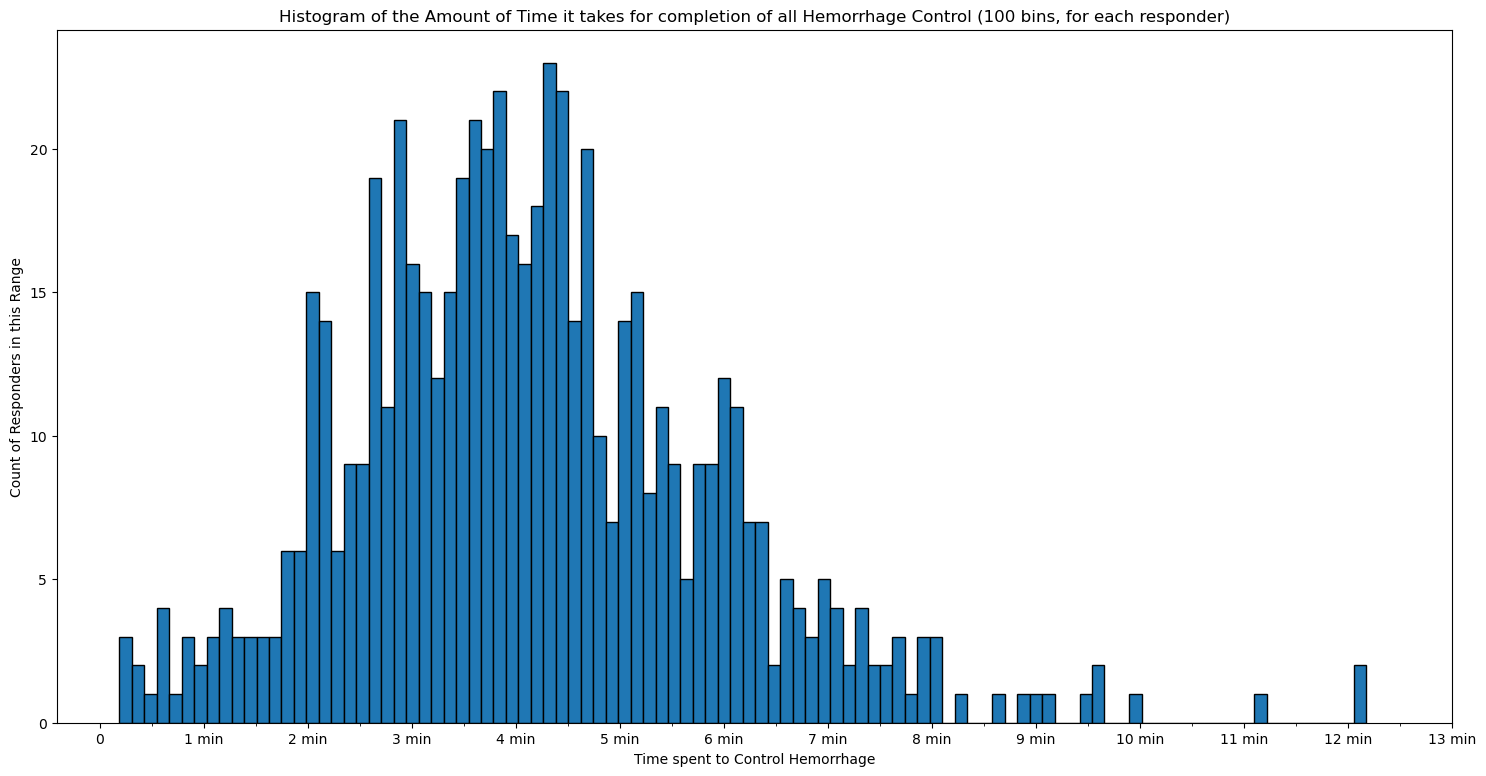

In [9]:

# Histogram of the time to hemorrhage control for the entire scene, ie completion of all the WoundPacks and Tourniquets in First11
mask_series = (notice_to_control_time_df.scene_type == 'Triage') & (notice_to_control_time_df.is_scene_aborted == False)
columns_list = [
    'notice_to_control_time', 'action_to_control_time'
]
tthc_df = notice_to_control_time_df[mask_series].groupby(fu.scene_groupby_columns)[columns_list].max()
xlabel = 'Time spent to Control Hemorrhage'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta_lambda(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the Amount of Time it takes for completion of all Hemorrhage Control (100 bins, for each responder)'
ylabel = 'Count of Responders in this Range'
ax = nu.plot_histogram(
    tthc_df, 'notice_to_control_time', xlabel=xlabel, xtick_text_fn=get_xtick_text,
    title=title, ylabel=ylabel, xticks_are_temporal=True
)

In [10]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
fu.show_time_statistics(tthc_df, columns_list)

mean mode median     SD min   25%    50%   75%     max
notice_to_control_time  4:09   11  4 min  ±1:45  11  2:57  4 min  5:09   12:10
action_to_control_time  3:47    0   3:39  ±1:46   0  2:38   3:39  4:50  12 min

In [ ]:

# Investigate the presence of hemorrhage control more broadly
# Define a function to check if a string contains the words "tourniquet" or "woundpack"
fn = lambda x: ('tourniquet' in str(x).lower()) or ('woundpack' in str(x).lower())

# Apply the lambda function to each element of the data frame, ignoring NaN values, and sum the results
srs = elevens_df.applymap(fn, na_action='ignore').sum()

# Create a list of column names with non-zero sums (indicating the presence of 'tourniquet' or 'woundpack')
columns_list = srs[srs != 0].index.tolist()

# Print the list of columns with non-zero sums
print(columns_list)

# Create a mask to filter rows where 'woundpack' is present in the 'voice_capture_message' column
mask_series = elevens_df.voice_capture_message.map(lambda x: ('woundpack' in str(x).lower()))

# Check if there are rows that meet the condition and print unique values of 'voice_capture_message'
if mask_series.any(): print(elevens_df[mask_series].voice_capture_message.unique().tolist())

# Create a mask to filter rows where 'woundpack' is present in the 'voice_command_command_description' column
mask_series = elevens_df.voice_command_command_description.map(lambda x: ('woundpack' in str(x).lower()))

# Check if there are rows that meet the condition and print unique values of 'voice_command_command_description'
if mask_series.any(): print(elevens_df[mask_series].voice_command_command_description.unique().tolist())

# Iterate through the columns with non-zero sums
for cn in columns_list:

    # Print the column name
    print(cn)
    
    # Create a mask to only include rows where the column contains the word "tourniquet" or "woundpack"
    mask_series = elevens_df[cn].map(fn)
    
    # Create a data frame with rows that meet the condition
    df = elevens_df[mask_series]
    
    # Display a sample of the data frame, dropping columns with all NaN values and transposing it
    display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

In [5]:

# Create a list of column names that end with '_required_procedure'
required_columns_list = [cn for cn in elevens_df.columns if cn.endswith('_required_procedure')]

# Create a mask series that is True for rows where the value of any of the required columns is 'tourniquet' or 'woundpack'
mask_series = False
for cn in required_columns_list: mask_series |= (elevens_df[cn].isin(['tourniquet', 'woundpack']))

# Apply the mask to the elevens_df to filter rows based on the condition
df = elevens_df[mask_series]

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

180479  \
action_type                                                                             INJURY_RECORD   
action_tick                                                                                    24646   
event_time                                                                        2023-08-02 09:50:45   
session_uuid                                                     638950ca-b008-4b14-bd07-933e16e7d8e0   
file_name                                           DCEMS Round 2 only triage sessions/638950ca-b0...   
logger_version                                                                                    1.0   
scene_id                                                                                          1   
injury_record_id                                                                     L Thigh Puncture   
injury_record_patient_id                                                                  Mike_7 Root   
injury_record_required_procedure                                                           tourniquet   
injury_record_severity                                                                         medium   
injury_record_body_region                                                                     leftLeg   
injury_record_injury_treated                                                                    False   
injury_record_injury_treated_with_wrong_treatment                                               False   
injury_record_injury_injury_locator                                                   (1.3, 0.6, 3.5)   
injury_treated_id                                                                                 NaN   
injury_treated_patient_id                                                                         NaN   
injury_treated_required_procedure                                                                 NaN   
injury_treated_severity                                                                           NaN   
injury_treated_body_region                                                                        NaN   
injury_treated_injury_treated                                                                     NaN   
injury_treated_injury_treated_with_wrong_treatment                                                NaN   
injury_treated_injury_injury_locator                                                              NaN   
patient_id                                                                                Mike_7 Root   
location_id                                                                           (1.3, 0.6, 3.5)   
injury_id                                                                            L Thigh Puncture   

                                                                                  252480  \
action_type                                                                INJURY_RECORD   
action_tick                                                                      245784   
event_time                                                           2022-03-16 10:23:53   
session_uuid                                        5c720560-85f5-4bb1-9aa5-41207f6259a2   
file_name                                                  Disaster Day 2022/HL_1034.csv   
logger_version                                                                       1.3   
scene_id                                                                             2   
injury_record_id                                                      L Wrist Amputation   
injury_record_patient_id                                                      Bob_0 Root   
injury_record_required_procedure                                              tourniquet   
injury_record_severity                                                              high   
injury_record_body_region                                                        leftArm   
injury_record_injury_treated                                         

In [7]:

# Show a sort of notice to control time
notice_to_control_time_df.sort_values('notice_to_control_time').head(5).T

858   \
logger_version                                               1.0   
session_uuid                6e3a5d8b-12c4-4afd-9a2e-619eb5b72b23   
scene_id                                                     1   
patient_id                                         Gloria_2 Root   
first_control                                              30718   
first_notice                                               20571   
injury_treated_body_region                               leftLeg   
notice_to_control_time                                     10147   
first_action                                               27971   
action_to_control_time                                      2747   

                                                                         802   \
logger_version                                                            1.3   
session_uuid                             67ed9702-0908-454a-8069-7ca4a6f2bee9   
scene_id                                                                  2   
patient_id                                                        Mike_5 Root   
first_control                                                          222429   
first_notice                                                           212151   
injury_treated_body_region  333366     abdomen
333374    rightLeg
333380  ...   
notice_to_control_time                                                  10278   
first_action                                                           216969   
action_to_control_time                                                   5460   

                                                            853   \
logger_version                                               1.0   
session_uuid                6d21f440-1c45-4c53-ad64-4edb92a94e25   
scene_id                                                     1   
patient_id                                           Mike_2 Root   
first_control                                              28351   
first_notice                                               17132   
injury_treated_body_region                                 chest   
notice_to_control_time                                     11219   
first_action                                               25042   
action_to_control_time                                      3309   

                                                            1457  \
logger_version                                               1.0   
session_uuid                c090fff8-5f81-40c5-b313-5fb7ce42ab9f   
scene_id                                                     1   
patient_id                                         Gloria_2 Root   
first_control                                              33510   
first_notice                                               22047   
injury_treated_body_region                               leftLeg   
notice_to_control_time                                     11463   
first_action                                               29815   
action_to_control_time                                      3695   

                                                            599   
logger_version                                               1.0  
session_uuid                48c426ae-e88c-49bd-8010-37dc7b042c95  
scene_id                                                     1  
patient_id                                         Gloria_2 Root  
first_control                                              49908  
first_notice                                               38444  
injury_treated_body_region                               leftLeg  
notice_to_control_time                                     11464  
first_action                                               46444  
action_to_control_time                                      3464

In [27]:

# Show a sort of notice to control time
notice_to_control_time_df.sort_values('notice_to_control_time').tail(5).T

631  \
logger_version                                                            1.3   
session_uuid                             4ca5febe-0a4b-4c77-bd3e-6632ae760df1   
scene_id                                                                  2   
patient_id                                                        Mike_5 Root   
first_control                                                          824957   
first_notice                                                           225423   
injury_treated_body_region  238801    rightLeg
238816     abdomen
238827  ...   
notice_to_control_time                                                 599534   
first_action                                                           245873   
action_to_control_time                                                 579084   

                                                                          502  \
logger_version                                                            1.0   
session_uuid                             38b995b3-fb77-4fda-b0b4-21f062ed6a38   
scene_id                                                                  1   
patient_id                                                        Mike_7 Root   
first_control                                                          640118   
first_notice                                                            15824   
injury_treated_body_region  538838     leftLeg
538858    rightLeg
Name: in...   
notice_to_control_time                                                 624294   
first_action                                                            65328   
action_to_control_time                                                 574790   

                                                             501  \
logger_version                                               1.0   
session_uuid                38b995b3-fb77-4fda-b0b4-21f062ed6a38   
scene_id                                                     1   
patient_id                                           Lily_4 Root   
first_control                                             684707   
first_notice                                               15824   
injury_treated_body_region                               abdomen   
notice_to_control_time                                    668883   
first_action                                               65328   
action_to_control_time                                    619379   

                                                                          796  \
logger_version                                                            1.3   
session_uuid                             677d1c18-f292-4bcb-924d-52f5e762533f   
scene_id                                                                  2   
patient_id                                                        Lily_4 Root   
first_control                                                         1167615   
first_notice                                                           441770   
injury_treated_body_region  231227    abdomen
231238    abdomen
Name: inju...   
notice_to_control_time                                                 725845   
first_action                                                          1151611   
action_to_control_time                                                  16004   

                                                             814  
logger_version                                               1.0  
session_uuid                684d04c4-83c1-49b6-b798-ddd431438857  
scene_id                                                     1  
patient_id                                           Lily_4 Root  
first_control                                             769367  
first_notice                                               38812  
injury_treated_body_region                               abdomen  
notice_to_control_time                                    730555  
first_action                                            

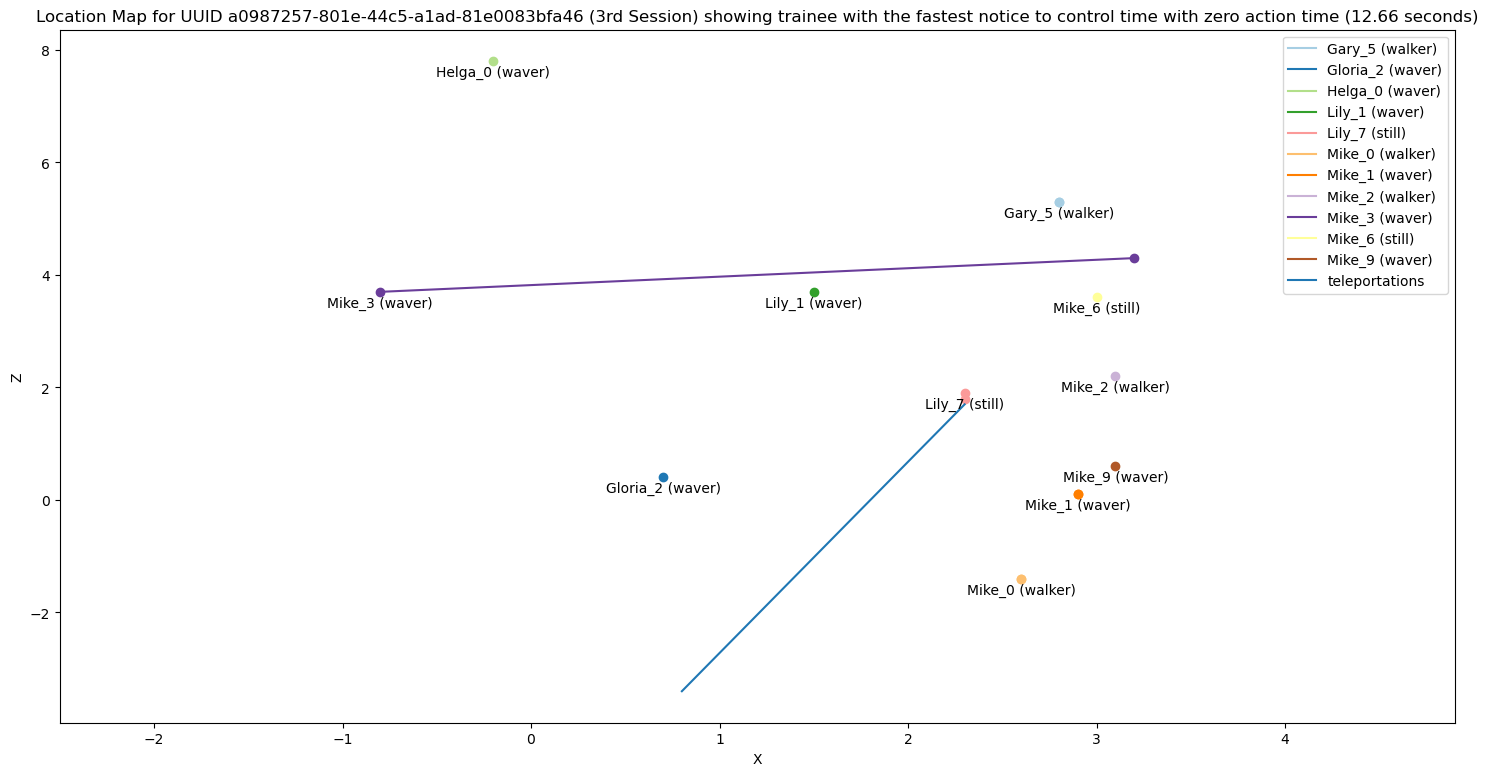

In [9]:

# Get scene with the fastest action to control time
mask_series = (notice_to_control_time_df.action_to_control_time == 0)
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'notice_to_control_time', mask_series=mask_series,
    is_ascending=True, title_str='fastest notice to control time with zero action time', verbose=False
)

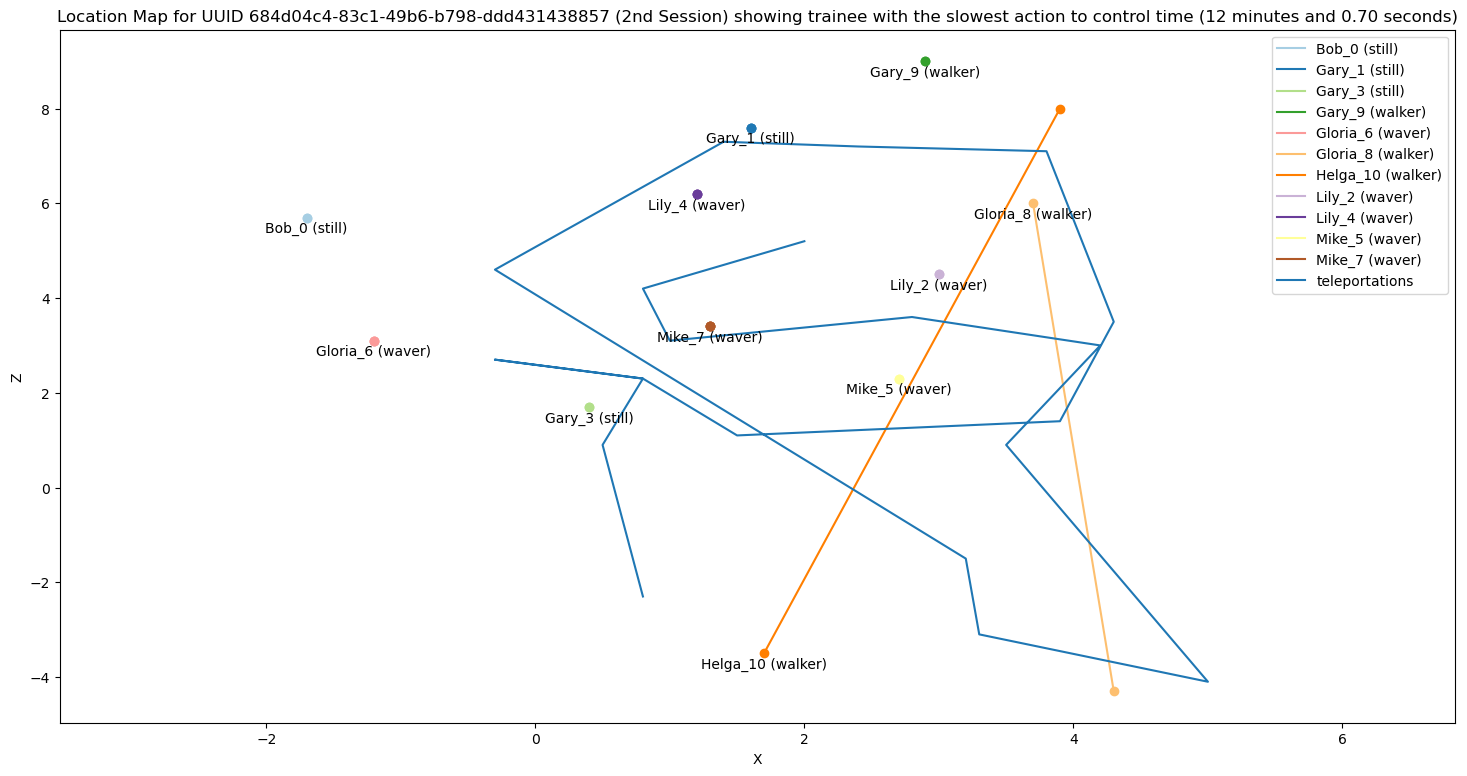

In [10]:

# Get scene with the slowest action to control time
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'action_to_control_time', mask_series=None,
    is_ascending=False, title_str='slowest action to control time', verbose=False
)

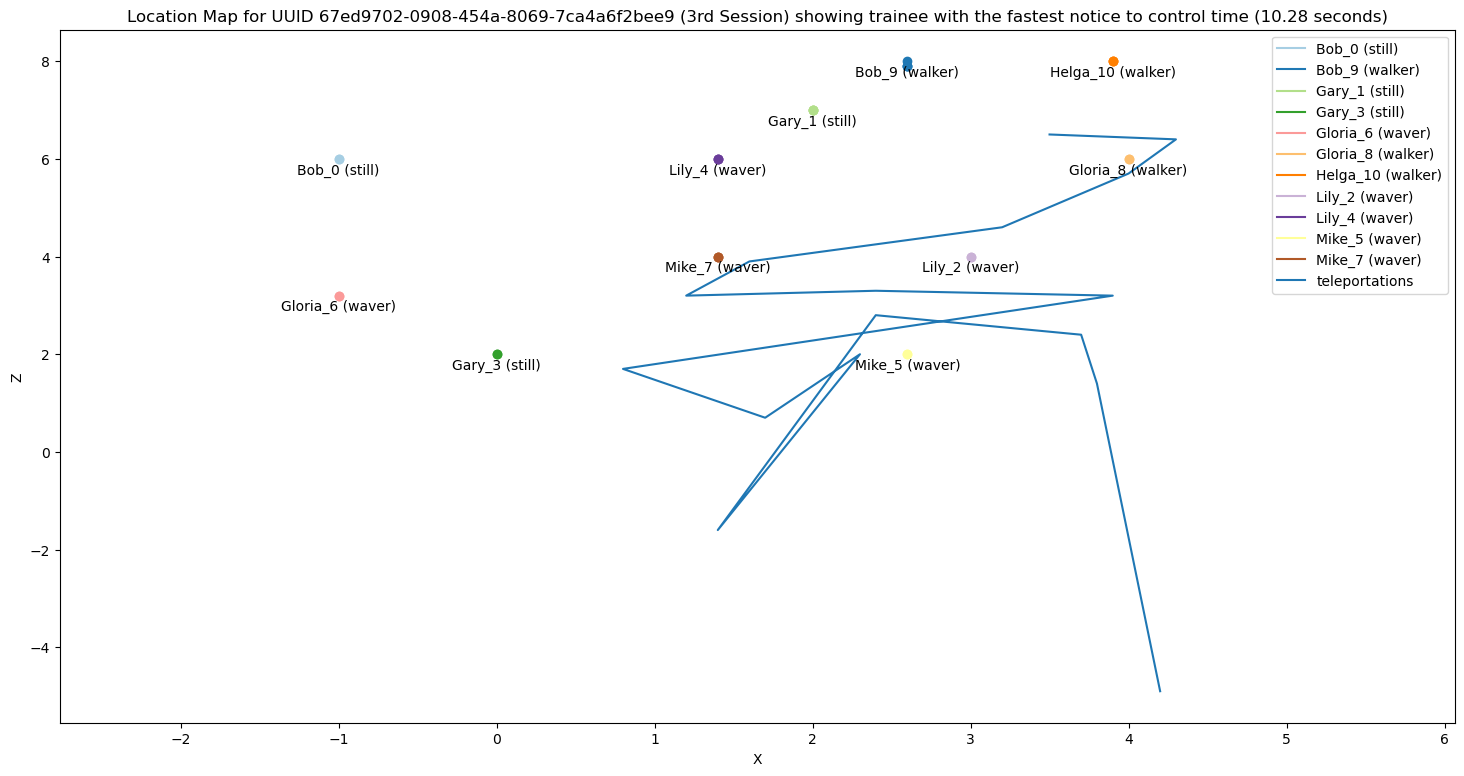

In [11]:

# Get scene with the fastest notice to control time, v1.3
mask_series = (notice_to_control_time_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'notice_to_control_time', mask_series=mask_series,
    is_ascending=True, title_str='fastest notice to control time', verbose=False
)

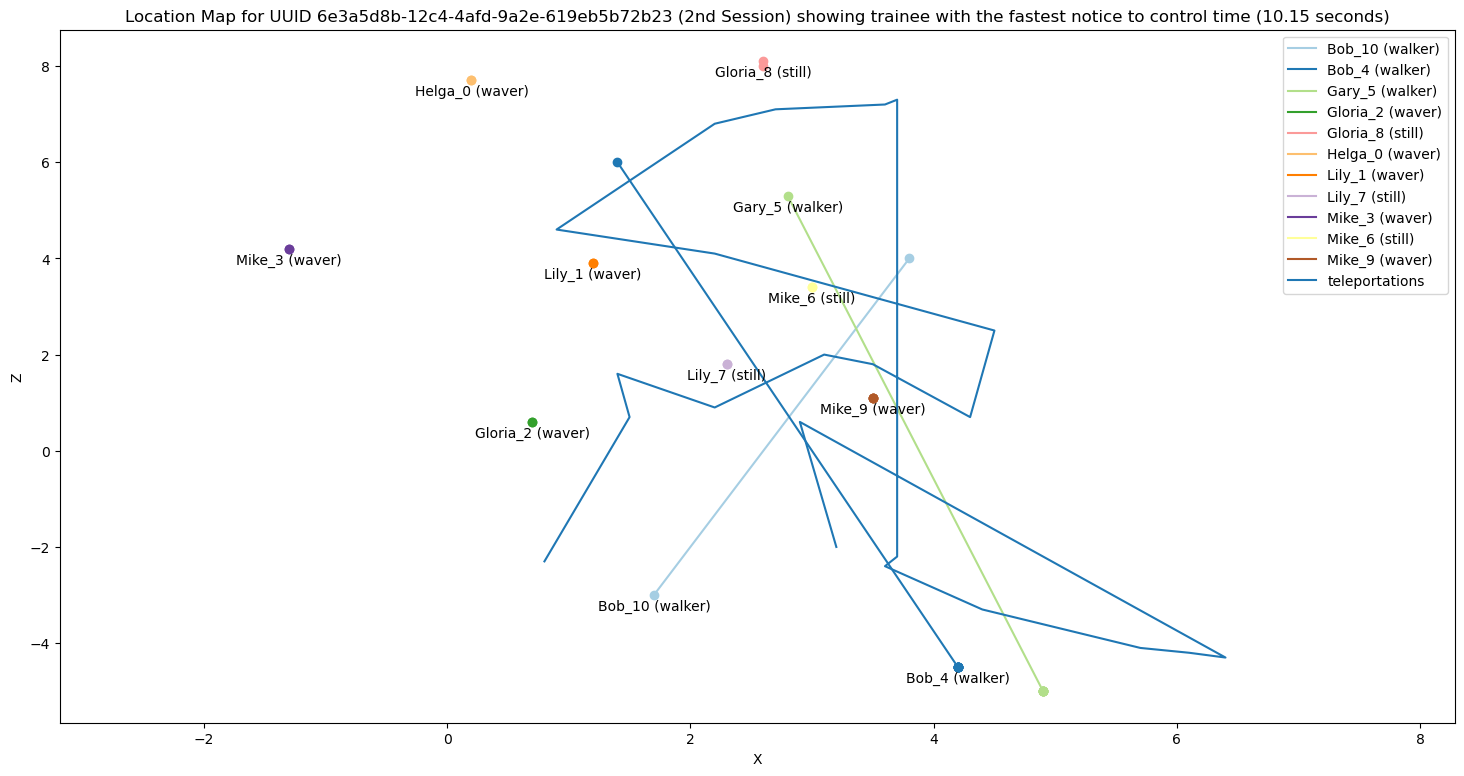

In [12]:

# Get scene with the fastest notice to control time, v1.0
mask_series = (notice_to_control_time_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'notice_to_control_time', mask_series=mask_series,
    is_ascending=True, title_str='fastest notice to control time', verbose=False
)

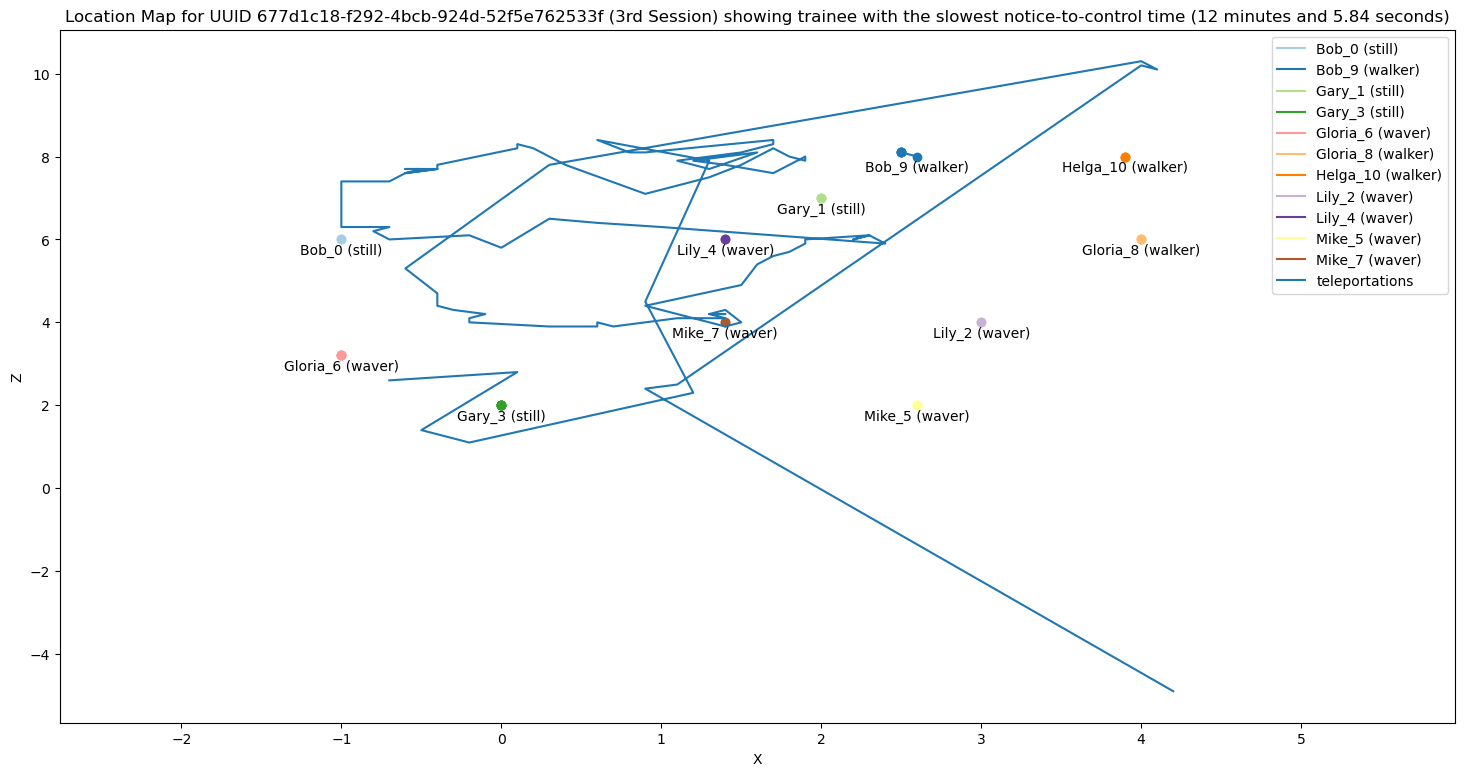

In [13]:

# Get scene with the slowest notice to control time, v1.3
mask_series = (notice_to_control_time_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'notice_to_control_time', mask_series=mask_series,
    is_ascending=False, title_str='slowest notice-to-control time', verbose=False
)

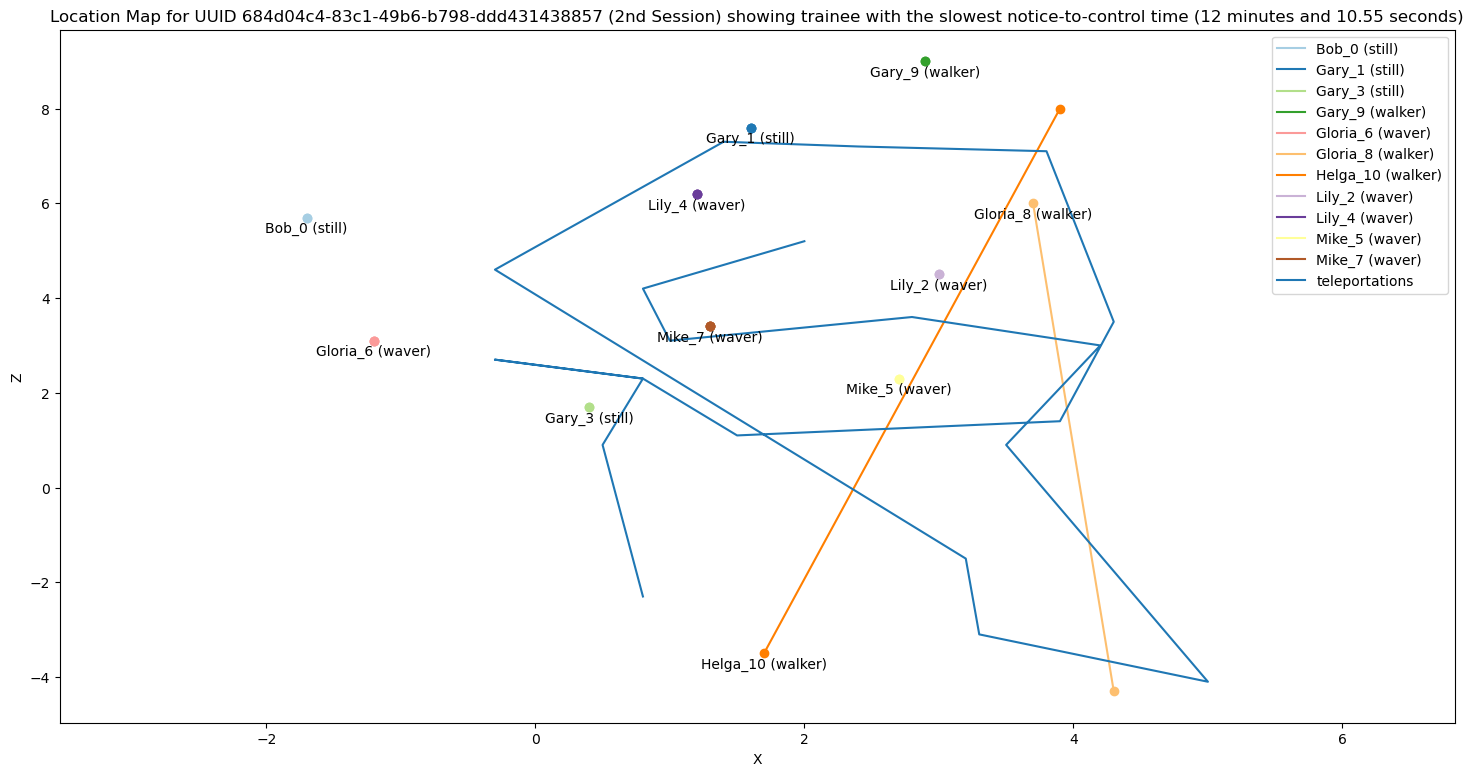

In [14]:

# Get scene with the slowest notice to control time, v1.0
mask_series = (notice_to_control_time_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    elevens_df, notice_to_control_time_df, 'notice_to_control_time', mask_series=mask_series,
    is_ascending=False, title_str='slowest notice-to-control time', verbose=False
)


Produce 1 graph for each of these statistics for the entire dataset


## Studying the misses

There are a total of 5 bleeding events that qualify as major arterial hemorrhage (Lily_2 Tourniquet, Lily_4 woundpack, Mike_5 woundpack & Tourniquet, and Mike_7 Tourniquet).

In [17]:

# Establish a definition of a missed bleeding event
df = notice_to_control_time_df.sort_values('notice_to_control_time')
missed_cutoff = df.tail(int(notice_to_control_time_df.shape[0]/10)).notice_to_control_time.min()
mask_series = (notice_to_control_time_df.notice_to_control_time < missed_cutoff)
notice_to_control_time_df[mask_series].notice_to_control_time.value_counts(bins=9)

(149890.111, 184825.889]    313
(184825.889, 219761.667]    272
(114954.333, 149890.111]    262
(219761.667, 254697.444]    240
(80018.556, 114954.333]     212
(254697.444, 289633.222]    175
(45082.778, 80018.556]      117
(289633.222, 324569.0]       98
(9832.577, 45082.778]        91
Name: notice_to_control_time, dtype: int64


Which bleeding events get missed the most (trunk, neck, junctional or extremity)?

In [24]:

# Get the trunk, neck, junctional or extremity info for each missed event
mask_series = (notice_to_control_time_df.notice_to_control_time >= missed_cutoff)

gb = notice_to_control_time_df[mask_series].groupby(fu.patient_groupby_columns)
for (session_uuid, scene_id, patient_id), patient_df in gb:
    
    # Get the patient's entire history
    mask_series = True
    for cn in fu.patient_groupby_columns: mask_series &= (elevens_df[cn] == eval(cn))
    df2 = elevens_df[mask_series]

    # Check for body region info
    mask_series = ~df2.injury_record_body_region.isnull() | ~df2.injury_treated_body_region.isnull()
    if mask_series.any():
        display(df2[mask_series].sample(min(4, df2[mask_series].shape[0])).dropna(axis='columns', how='all').T)
        break

35754  \
action_type                                                                            INJURY_TREATED   
action_tick                                                                                   386013   
event_time                                                                        2023-03-14 12:38:08   
session_uuid                                                     00b2e9d8-c3bb-4d89-92c1-abce5c4a0655   
file_name                                           All CSV files renamed by date/03.14.23.1247-40...   
logger_version                                                                                    1.0   
scene_id                                                                                          1   
injury_record_id                                                                                  NaN   
injury_record_patient_id                                                                          NaN   
injury_record_required_procedure                                                                  NaN   
injury_record_severity                                                                            NaN   
injury_record_body_region                                                                         NaN   
injury_record_injury_treated                                                                      NaN   
injury_record_injury_treated_with_wrong_treatment                                                 NaN   
injury_record_injury_injury_locator                                                               NaN   
injury_treated_id                                                                 L Shoulder Puncture   
injury_treated_patient_id                                                                 Mike_2 Root   
injury_treated_required_procedure                                                           woundpack   
injury_treated_severity                                                                        medium   
injury_treated_body_region                                                                      chest   
injury_treated_injury_treated                                                                    True   
injury_treated_injury_treated_with_wrong_treatment                                              False   
injury_treated_injury_injury_locator                                                 (2.9, 1.4, -5.0)   
patient_id                                                                                Mike_2 Root   
location_id                                                                          (2.9, 1.4, -5.0)   
injury_id                                                                         L Shoulder Puncture   

                                                                                                35415  
action_type                                                                             INJURY_RECORD  
action_tick                                                                                    16483  
event_time                                                                        2023-03-14 12:31:58  
session_uuid                                                     00b2e9d8-c3bb-4d89-92c1-abce5c4a0655  
file_name                                           All CSV files renamed by date/03.14.23.1247-40...  
logger_version                                                                                    1.0  
scene_id                                                                                          1  
injury_record_id                                                                  L Shoulder Puncture  
injury_record_patient_id                                                                  Mike_2 Root  
injury_record_required_procedure                                                            woundpack  
injury_record_severity                                                                         medium  
injury_record_body

In [22]:

columns_list = [
    'injury_record_id', 'injury_record_body_region', 'injury_treated_id', 'injury_treated_body_region',
    'injury_id'
]
for cn in columns_list:
    sample_list = elevens_df[cn].unique()
    if len(sample_list) < 20:
        print(cn, sample_list)

injury_record_body_region [nan 'rightArm' 'leftLeg' 'chest' 'head' 'leftArm' 'abdomen' 'rightLeg'
 'neck']
injury_treated_body_region [nan 'chest' 'leftLeg' 'rightArm' 'rightLeg' 'abdomen' 'leftArm' 'head'
 'neck']


What goes into why they were missed (patient location, patient position, patient level of consciousness, etc.)?

What activities occurred prior to completion of hemorrhage control?